<font size="10"> <center> ![alt text](logo1.png)

**Università della Svizzera italiana**

![alt text](logo2.png)

<br>
<br>
<font size="8"> Computer Vision & Pattern Recognition <br><br> (Spring 2024)</font>

<br>
<br>
<br>
<br>
<font size="6"> Goal: Reconstruct Snooker Table and Balls from Side View


<br>
<br>
    
<font size="3"> <center> _Submitted By_: <br> **Erifeoluwa Jamgbadi | `jamgbe@usi.ch` <br> Krunal Rathod | `krunal.rathod@usi.ch`  <br> Riccardo Giacometti | `riccardo.giacometti@usi.ch`**

<font size="3"> <center> _Submitted On_: 10 June 2024
    
    
<br>
<br>

In [4]:
#from process_video import preprocess_video
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<br>

TASK 1: Process The Video and Filter Only Side View Frames

<br>


In [300]:

def preprocess_video(video_path, reference_frame, output_path=None):
  """Preprocesses a video and filters only the frames that show a side view of a snooker table.

  Args:
    video_path: The path to the video file.
    reference_frame: A reference frame that shows a side view of the snooker table.
    output_path: The path to save the filtered video (default: None).

  Returns:
    filtered side view frames (video file if output_path is given).
  """

  # read the video
  cap = cv2.VideoCapture(video_path)
  cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"XVID"))

  # get the width and height of frame
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # define a threshold for the number of matching pixels of ref. frame
  matching_pixel_threshold = 0.5 * frame_width * frame_height

  # list to store the filtered frames
  filtered_frames = []

  # video writer
  writer = None
  if output_path: # write video only if path is given
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    fps = cap.get(cv2.CAP_PROP_FPS)
    writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

  # maximum number of frames to process certain frames (optional)
  max_frames = None  # set to a number or otherwise for processing all frames

  while True:
    # read frame
    ret, frame = cap.read()

    # check if frame is read correctly or if max frames reached
    if not ret or (max_frames is not None and len(filtered_frames) >= max_frames):
      break

    # converts the frame and reference frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_reference_frame = cv2.cvtColor(reference_frame, cv2.COLOR_BGR2GRAY)

    # calculates the absolute difference between the original video frame and the reference frame
    diff = cv2.absdiff(gray_frame, gray_reference_frame)

    # count the number of matching pixels
    matching_pixels = np.count_nonzero(diff < 10)

    # check if the number of matching pixels is above the threshold
    if matching_pixels > matching_pixel_threshold:
      filtered_frames.append(frame)

      # display the filtered frame 
      cv2.imshow("Filtered Frame", frame)
      cv2.waitKey(1)

    # write frame to video if output_path is given
      if writer:
          writer.write(frame)

  cap.release()
  writer.release()
  cv2.destroyAllWindows()

  return filtered_frames

In [7]:
##works on mac
video_path = "../CVPR_Project/WSC_sample.mp4"
reference_frame = cv2.imread("input/reference_image.png")
output_path = "output/filtered_video_sample.mp4"

preprocess_video(video_path, reference_frame, output_path)

[]

<br>

TASK 2: Reconstruct Camera Position

<br>

In [301]:
img = cv2.imread("input/reference_image.png")

In [302]:
def padding(img):
    padSize = 31
    
    rows = img.shape[0]
    columns = img.shape[1]

    padImg = np.zeros((rows+2*padSize, columns+2*padSize), dtype=np.uint8)
    # using Slicing
    padImg[padSize:rows+padSize, padSize:columns+padSize] = img
    return padImg

In [303]:
#code from https://github.com/zain-ul-abaidin/Digital-Image-Processing/blob/master/Erosion-Morphological-Operation-Without-Build-in.py

def Erosion(padImg, kernel, size):
    
    rows = padImg.shape[0]
    columns = padImg.shape[1]

    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # Slicing
            portion = padImg[i:i+size, j:j+size]
            portion1 = portion.flatten()
            portion2 = kernel.flatten()
            # sum of kernel and window
            p1 = (np.sum(portion1))
            p2 = (np.sum(portion2))*255
            # if Fit condition satisfies
            if p1 == p2:
                output[i, j] = 255
            else:
                output[i, j] = np.min(portion1)
    return output

In [304]:
###smooth the img and get the corners needed

def smoothImgNGetCorners(imgMask):
    size = 31
    
    kernel = np.ones((size, size), np.uint8)
    erosion = Erosion(imgMask, kernel, size//2 )
    dilation = cv2.dilate(erosion, kernel, iterations=1)


    canny = cv2.Canny(dilation, 100, 200)
    kernel = np.ones((7, 7), np.uint8)
    canny = cv2.dilate(canny, kernel, iterations=1)

    contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        print(f"the width is {w} and the height is {h}")
    
    cnt = contours[0]

    # just get 4 points
    poly = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    inner_corner = [[x,y] for [[x,y]] in poly]

    #print(inner_corner)
    return inner_corner


In [305]:

##put the points found in the img and display
def displayPointsInImg(img, corners):
    for point in corners:
        cv2.circle(img, point, radius=5, color=(255, 0, 0), thickness =5)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

<br>

measure the playing area

<br>

slowed down the code by using BGR2HSV so just included to show implementation

In [306]:
# #changed the code from https://github.com/zain-ul-abaidin/Digital-Image-Processing/blob/master/BGR2HSV-Hue-Saturation-Intensity-without-Build-in.py


# def BGR2HSV(img):
#     r = img.shape[0]
#     c = img.shape[1]


#     H = np.zeros((r, c), dtype=np.uint8)
#     S = np.zeros((r, c), dtype=np.uint8)
#     V = np.zeros((r, c), dtype=np.uint8)
#     for i in range(r):
#         for j in range(c):
#             # pixel with R, G and B values in array
#             pix = img[i, j]
#             # The R,G, B values are divided by 255 for the normalization
#             B = pix[0] / 255
#             G = pix[1] / 255
#             R = pix[2] / 255
#             array = [B, G, R]
#             Cmax = np.max(array)
#             Cmin = np.min(array)
#             Delta = Cmax - Cmin
#             # Hue Calculation
#             if Delta == 0:
#                 H[i, j] = 0
#             elif Cmax == R:
#                 H[i, j] = 60 * np.mod((G - B) / Delta, 6)
#             elif Cmax == G:
#                 H[i, j] = 60 * (((B - R) / Delta) + 2)
#             elif Cmax == B:
#                 H[i, j] = 60 * (((R - G) / Delta) + 4)
#             # Saturation Calculation
#             if Cmax == 0:
#                 S[i, j] = 0
#             else:
#                 S[i, j] = (Delta / Cmax)
#             # Intensity Value
#             V[i, j] = Cmax


#     ###normalised 
#     minimum = np.min(H)
#     maximum = np.max(H)
#     normImgOne = np.zeros((r, c), dtype=np.uint8)
#     for i in range(0, r):
#         for j in range(0, c):
#             # Using Normalization Formula
#             normImgOne[i][j] = (255*(H[i][j]-minimum))//(maximum-minimum)
            
#     minimum = np.min(S)
#     maximum = np.max(S)
#     normImgTwo = np.zeros((r, c), dtype=np.uint8)
#     for i in range(0, r):
#         for j in range(0, c):
#             # Using Normalization Formula
#             normImgTwo[i][j] = (255*(S[i][j]-minimum))//(maximum-minimum)
            
#     minimum = np.min(V)
#     maximum = np.max(V)
#     normImgThree = np.zeros((r, c), dtype=np.uint8)
#     for i in range(0, r):
#         for j in range(0, c):
#             # Using Normalization Formula
#             normImgThree[i][j] = (255*(V[i][j]-minimum))//(maximum-minimum)
            
#     ##merge hsv to get one form
#     hsvMerged = cv2.merge((normImgOne, normImgTwo, normImgThree))
    

#     cv2.imshow('HSV', hsvMerged)
#     cv2.waitKey(0)
            
#     return hsvMerged

In [307]:
###to detect the green playing area - https://stackoverflow.com/questions/47483951/how-can-i-define-a-threshold-value-to-detect-only-green-colour-objects-in-an-ima

img = cv2.imread("input/reference_image.png")

def findCornersOfGreenPlayArea(img):

    lower_green = np.array([36,0,0])
    upper_green = np.array([86, 255, 255])

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  #BGR2HSV(img) 
    mask = cv2.inRange(hsv_img, lower_green, upper_green)


    imask = mask>0
    green = np.zeros_like(img, np.uint8)
    green[imask] = img[imask]
    
    
    # plt.figure(figsize=(10, 8))
    plt.imshow(mask)
    
    ##get the corner points
    greenCorners = smoothImgNGetCorners(mask)
    return greenCorners


## saved the green area img so it can be used later
#cv2.imwrite("output/greenPlayingArea.png", green)

the width is 861 and the height is 613
the width is 849 and the height is 601
the width is 71 and the height is 62
the width is 49 and the height is 27


The coodinates of the corners are 

[[337, 31], [202, 631], [1061, 631], [926, 31]]


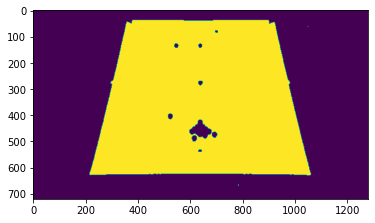

In [308]:
###find the coordinates of the green playing area
img = cv2.imread("output/greenPlayingArea.png",1)

greenCornersFound = findCornersOfGreenPlayArea(img)

displayPointsInImg(img, greenCornersFound)

print("\n\nThe coodinates of the corners are \n")
print(greenCornersFound)

#plt.imshow(img)

In [309]:
#https://stackoverflow.com/questions/46112326/what-is-the-range-of-hsv-values-for-brown-color-in-opencv#:~:text=In%20HSV%2C%20browns%20correspond%20to,degrees%20for%20a%20sand%20color.


def maskCushionBrown(img):
    ##if u don't include dtype it causes an error later on with the mask
    lower_brown = np.array([10, 100, 20], dtype=np.uint8)
    upper_brown = np.array([100, 255, 200], dtype=np.uint8)

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    
    imask = mask>0
    brownC = np.zeros_like(img, np.uint8)
    brownC[imask] = img[imask]
    
    brownC = cv2.cvtColor(brownC, cv2.COLOR_BGR2GRAY)
    
    
    # plt.figure(figsize=(10, 8))
    #plt.imshow(brownC)

    return brownC

In [310]:
##get the points of the cushion
img = cv2.imread("input/reference_image.png")

#obtain the mask
imgMask = maskCushionBrown(img)

#Display the result
cv2.imshow('region', imgMask)
cv2.waitKey(0)
cv2.destroyAllWindows()
    
##get the corner points
brownCorners = smoothImgNGetCorners(imgMask)

displayPointsInImg(img, brownCorners)

print("\n\nThe coodinates of the corners are \n")
print(brownCorners)

the width is 46 and the height is 46
the width is 34 and the height is 34
the width is 808 and the height is 12
the width is 11 and the height is 12
the width is 10 and the height is 12
the width is 70 and the height is 58
the width is 84 and the height is 334
the width is 772 and the height is 589


The coodinates of the corners are 

[[1022, 648], [1022, 691], [1067, 691], [1067, 646]]


<br>

measure the sides of playing area

<br>

In [311]:
# used to calculate the distance between 2 points
def euclidean_distance(pt1, pt2):
    return int(np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2))

In [312]:
##used to get the length and width of cushion area to calculate the area
def findLengthOfSide(img):

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    box = cv2.minAreaRect(cnt)
    pointsFoundFromRect = cv2.boxPoints(box).astype(np.int32)
    print(pointsFoundFromRect)


    ##these are the lengths of the playing area found
    sideLen = [euclidean_distance(pointsFoundFromRect[i], pointsFoundFromRect[(i+1) % 4]) for i in range(4)]
    #print(sideLen)

    ##just chose the first 2 lengths as the measurement is the same or off by 1
    selectedLength = sideLen[:2]

    #print(selectedLength)
    return selectedLength

<br>

use Sobel gradients and Hough transform to find lines between baize (green) and wood (brown) and intersect

<br>

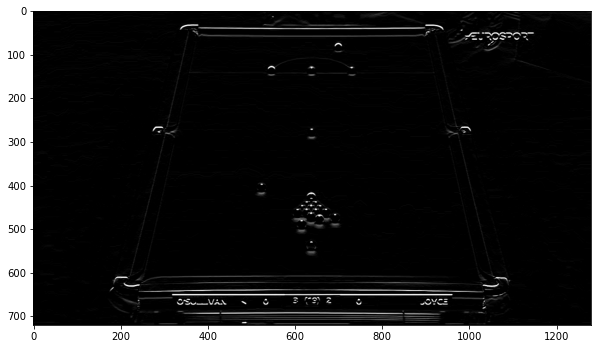

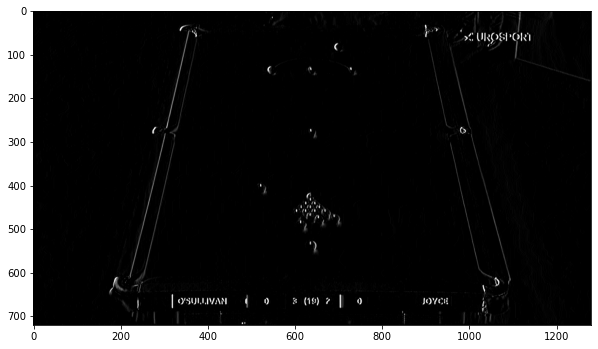

In [313]:
#code from https://github.com/wliang6/Sobel-Filter-Implementation/blob/master/Code/1Dconvolution.py
    
# Load the image
img = cv2.imread("input/reference_image.png",0)

#Sobel Separable Filter in x direction
sobelx1 = np.array([[1,2,1]], dtype = np.float64)  #column
sobelx2 = np.array([[-1,0,1]], dtype = np.float64) #row


#Sobel Separable Filter in y direction
sobely1 = np.array([[-1,0,1]], dtype = np.float64) #column
sobely2 = np.array([[1,2,1]], dtype = np.float64)  #row



#Calculate gx and gy using Sobel (horizontal and vertical gradients)
gx = cv2.sepFilter2D(img, -1, sobelx2, sobelx1)
gy = cv2.sepFilter2D(img, -1, sobely2, sobely1)

#Calculate the gradient magnitude
g = np.sqrt(gx * gx + gy * gy)

#Normalize output to fit the range 0-255
g *= 255.0 / np.max(g)


#Hough Transform to detect lines
#cannied = cv2.Canny(img, 50, 200, 3)
lines = cv2.HoughLinesP(gy,  3.5, theta=np.pi/180, threshold=100)

plt.figure(figsize=(10, 8))
plt.imshow(gy, cmap=plt.cm.gray)   

plt.figure(figsize=(10, 10))
plt.imshow(gx, cmap=plt.cm.gray)   

plt.show()



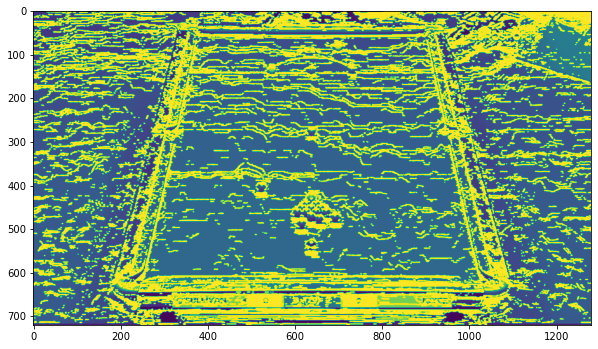

In [314]:
##line of intersection - code from https://mason.gmu.edu/~sdixit4/

houghP_lines = []

for line in lines:    
    for x1,y1,x2,y2 in line:
        houghP_lines.append(((x1,y1),(x2,y2)));
        cv2.line(img, (x1,y1), (x2,y2), (255, 255, 255), 2, cv2.LINE_AA);
        
plt.figure(figsize=(10, 8))
plt.imshow(img)

def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

##thre were too many lines, so the functionwas slow
# def line_intersection(line1, line2):
#     x_diff = (line1[0][0] - line1[0][0], line2[0][0] - line2[0][0])
#     y_diff = (line1[0][0] - line1[0][0],line2[0][0]- line2[0][0])

#     div = det(x_diff, y_diff)
#     if div == 0:
#         return None  # Lines don't cross

#     d = (det(*line1), det(*line2))
#     x = det(d, x_diff) / div
#     y = det(d, y_diff) / div

#     return x, y

# #Question 4
# # Find intersections between multiple lines
# def find_intersections(lines):
#     intersections = []
#     for i, line_1 in enumerate(lines):
#         for line_2 in lines[i + 1:]:
#             if not line_1.all() == line_2.all():
#                 intersection = line_intersection(line_1, line_2)
#                 if intersection:  # If lines cross, then add
#                     intersections.append(intersection)

#     return intersections


# findInt = find_intersections(lines)

In [315]:
#https://forum.opencv.org/t/how-to-find-intersection-points-of-lines-in-an-image-opencv-using-houghlines-and-how-to-find-if-lines-dont-have-intersection-points/1228
    
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
line_color = [0, 0, 255]
line_thickness = 2
dot_color = [0, 255, 0]
dot_size = 1

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.circle(line_img, (x1, y1), dot_size, dot_color, -1)
        cv2.circle(line_img, (x2, y2), dot_size, dot_color, -1)

cv2.imshow('hh', line_img)
cv2.waitKey(0)

-1

In [316]:
##the length, width and area cushion area

finalLengthOfCushion = findLengthOfSide(gx)

print("\nThe length and width of the playing area is")
print(finalLengthOfCushion[0]/100, finalLengthOfCushion[1]/100)
area = (finalLengthOfCushion[0] / 100) * (finalLengthOfCushion[1] / 100)

print("\n\n")
print(f"The area of the cushion area is {area} meters")


[[165 675]
 [338  12]
 [555  68]
 [382 732]]

The length and width of the playing area is
6.85 2.24



The area of the cushion area is 15.344000000000001 meters


<br>

6 table corners and then the 4 cushion(brown corners) using user clicks (note the points changed a bit, because we ran the the file again)

<br>

In [123]:
# Load the image to get the table and cushion position

img = cv2.imread('input/reference_image.png')

# Display the image and allow user to select points
points = []

def select_point(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 11:
        points.append((x, y))
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv2.putText(img, str(len(points)), (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.imshow("Image", img)

cv2.namedWindow("Image")
cv2.setMouseCallback("Image", select_point)

while True:
    cv2.imshow("Image", img)
    if cv2.waitKey(0) or len(points) == 10: 
        break

cv2.destroyAllWindows()


# Convert selected points to numpy array
tableNCushionCorners = np.array(points)
print(tableNCushionCorners)

[[ 378   54]
 [ 903   56]
 [ 309  279]
 [ 979  278]
 [ 238  619]
 [1036  616]
 [ 347   38]
 [ 930   35]
 [ 196  635]
 [1074  635]]


In [131]:
heightOfSnooker = 0.881 
##repeated value in each array for some reason
import pandas as pd

##https://help.maptek.com/mapteksdk/1.5/topics/common-operations/converting-2d-points-to-3d.htm
def twodToThreeD(i):
    points_3d = np.empty((len(i), 3), dtype=np.float64)
    points_3d[:, :2] = i
    points_3d[:, 2] = 0.02625
    return points_3d
    
for i in tableNCushionCorners:
    c =  twodToThreeD(i)
    print(c)

[[3.780e+02 5.400e+01 2.625e-02]
 [3.780e+02 5.400e+01 2.625e-02]]
[[9.030e+02 5.600e+01 2.625e-02]
 [9.030e+02 5.600e+01 2.625e-02]]
[[3.090e+02 2.790e+02 2.625e-02]
 [3.090e+02 2.790e+02 2.625e-02]]
[[9.790e+02 2.780e+02 2.625e-02]
 [9.790e+02 2.780e+02 2.625e-02]]
[[2.380e+02 6.190e+02 2.625e-02]
 [2.380e+02 6.190e+02 2.625e-02]]
[[1.036e+03 6.160e+02 2.625e-02]
 [1.036e+03 6.160e+02 2.625e-02]]
[[3.470e+02 3.800e+01 2.625e-02]
 [3.470e+02 3.800e+01 2.625e-02]]
[[9.300e+02 3.500e+01 2.625e-02]
 [9.300e+02 3.500e+01 2.625e-02]]
[[1.960e+02 6.350e+02 2.625e-02]
 [1.960e+02 6.350e+02 2.625e-02]]
[[1.074e+03 6.350e+02 2.625e-02]
 [1.074e+03 6.350e+02 2.625e-02]]


<br>

ball positions : compute coordinates of the (yellow, green, brown, blue, pink, black) spots

<br>

In [67]:
# Load the image and read the world coordinates to get the ball positions
img = cv2.imread('input/reference_image.png')

# Display the image and allow user to select 6 points (do in order of the specific colour)
points = []

def select_point(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 7:
        points.append((x, y))
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv2.putText(img, str(len(points)), (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.imshow("Image", img)

cv2.namedWindow("Image")
cv2.setMouseCallback("Image", select_point)

while True:
    cv2.imshow("Image", img)
    if cv2.waitKey(0) or len(points) == 6:  # Press Esc or select 6(yellow, green, brown, blue, pink, black ball points) to exit
        break

cv2.destroyAllWindows()


# Convert selected points to numpy array
selected_points = np.array(points)

In [68]:
print(selected_points)

[[547 134]
 [732 135]
 [640 134]
 [640 276]
 [638 423]
 [640 535]]


In [132]:
def gaussian_blur(image, kernel_size=5, sigma=1.0):
    def create_gaussian_kernel(kernel_size, sigma):
        """Creates a Gaussian kernel."""
        ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
        return kernel / np.sum(kernel)

    def apply_kernel(image, kernel):
        """Applies a kernel to the image."""
        image_height, image_width = image.shape
        kernel_size = kernel.shape[0]
        pad_width = kernel_size // 2

        # Pad the image with the edge values
        padded_image = np.pad(image, pad_width, mode='edge')
        blurred_image = np.zeros_like(image)

        # Apply the kernel to each pixel in the image
        for i in range(image_height):
            for j in range(image_width):
                region = padded_image[i:i + kernel_size, j:j + kernel_size]
                blurred_image[i, j] = np.sum(region * kernel)
        
        return blurred_image

    if len(image.shape) == 3:  # If the image has multiple channels
        channels = image.shape[2]
        blurred_image = np.zeros_like(image)
        kernel = create_gaussian_kernel(kernel_size, sigma)
        for c in range(channels):
            blurred_image[:, :, c] = apply_kernel(image[:, :, c], kernel)
    else:  # If the image is grayscale
        kernel = create_gaussian_kernel(kernel_size, sigma)
        blurred_image = apply_kernel(image, kernel)

    return blurred_image

In [133]:
###define colour ranges and mask

def detectColourBall(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    ###implement ranges for the different colours
    lower_yellow = np.array([20, 100, 100], dtype=np.uint8)
    upper_yellow = np.array([30, 255, 255], dtype=np.uint8)
    mask1 = cv2.inRange(hsv, lower_yellow, upper_yellow)


    lower_brown = np.array([10, 100, 20], dtype=np.uint8)
    upper_brown = np.array([20, 255, 200], dtype=np.uint8)
    mask2 = cv2.inRange(hsv, lower_brown, upper_brown)


    lower_green = np.array([35, 0, 0], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)
    mask3 = cv2.inRange(hsv, lower_green, upper_green)


    lower_blue = np.array([90, 100, 100], dtype=np.uint8)
    upper_blue = np.array([130, 255, 255], dtype=np.uint8)
    mask4 = cv2.inRange(hsv, lower_blue, upper_blue)


    lower_pink = np.array([140, 50, 200], dtype=np.uint8)
    upper_pink = np.array([170, 255, 255], dtype=np.uint8)
    mask5 = cv2.inRange(hsv, lower_pink, upper_pink)


    lower_black = np.array([0, 0, 0], dtype=np.uint8)
    upper_black = np.array([180, 255, 30], dtype=np.uint8)
    mask6 = cv2.inRange(hsv, lower_black, upper_black)


    # Combine the masks
    mask = cv2.bitwise_or(mask1, mask2)
    mask = cv2.bitwise_or(mask, mask3)
    mask = cv2.bitwise_or(mask, mask4)
    mask = cv2.bitwise_or(mask, mask5)
    mask = cv2.bitwise_or(mask, mask6)
    result = cv2.bitwise_and(img, img, mask=mask)


    plt.figure(figsize=(10, 8))
    plt.title('Detected colour balls')
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


    plt.figure(figsize=(10, 8))
    imgray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)

    return imgray

    

In [293]:
##do the detected circles on the image and get their position

def circleIdentify(imgray):
    blurred = gaussian_blur(imgray, kernel_size=5, sigma=2.0)

    # Use hough circles because the contours look circular-ish
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=0.2, 
        minDist=10, 
        param1=20, 
        param2=6, 
        minRadius=3, 
        maxRadius=5
    )

    # Prepare the output image
    output = img.copy()
    circle_centers = []
    cordinatesOfCircle = []

    # Check if circles are detected
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Draw the circle in the output image
            cv2.circle(output, (x, y), r, (0, 0, 0), 2)
            cordinatesOfCircle.append((x,y))
            
            # Store the center of the circle
            circle_centers.append((x, y))
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        circle_centers = np.array(circle_centers)

    return cordinatesOfCircle
                
        


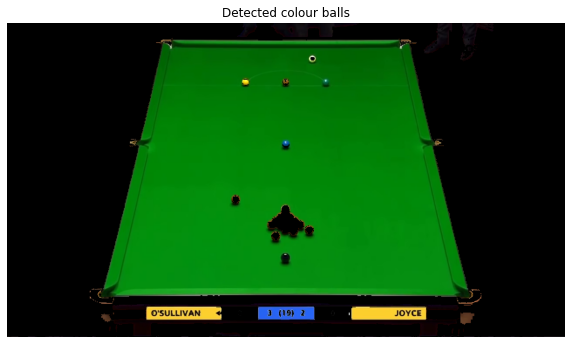

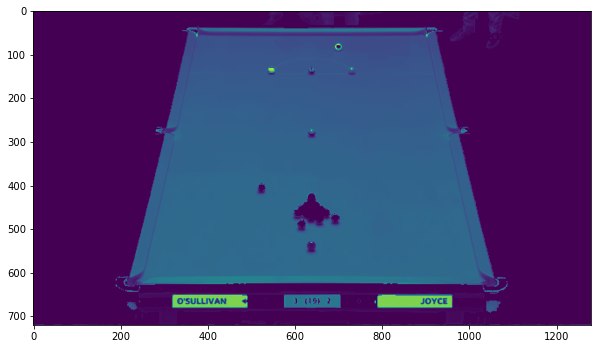

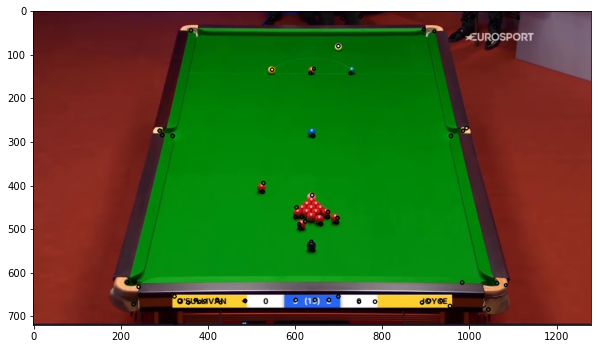

In [294]:
##detect the colour balls in the img

img = cv2.imread("input/reference_image.png")

imgray = detectColourBall(img)
circleCoord = circleIdentify(imgray)
#print(len(circleCoord))

In [299]:
###the coordinates of the circles 
##73 was found cause of the false detection while we only needed 6 
print(len(circleCoord))


##these are the points found in the circleArray that are similar to the mouse click ones
finalCoordColour = []


element = [(548, 134), (728, 142), (644, 132),(642, 286), (640, 422), (642, 548)]
for i in element:
    index = circleCoord.index(i)
    print(index)
    finalCoordColour.append( circleCoord[index])
    
print("these are the coordinates of the colour balls obtained")
finalCoordColour
# (548, 134),
# (728, 142),
# (644, 132),
# (642, 286),
# (640, 422),
# (642, 548)

73
28
21
57
30
61
42


[(548, 134), (728, 142), (644, 132), (642, 286), (640, 422), (642, 548)]

<br>

use correspondence pairs to find camera matrix

<br>

In [41]:
#  the four corners of the "playing area" with cushion height,  and the six ball markers at table height
xyz = np.array([[-0.889, -1.7845, 0.03], [0.889, -1.7845, 0.03], [0.889,  1.7845, 0.03], [-0.889,  1.7845, 0.03], [-0.292, 1.0475, 0], [0.292, 1.0475, 0],[0, 1.0475, 0], [0, 0, 0], [0,-0.89225, 0], [0,-1.4605, 0]])
    
    
uv =  np.array([[253, 608], [1027, 608], [904,  47], [376,  47], [548, 143], [732, 143], [640, 143], [640, 287], [640, 437], [640, 549]])

In [42]:
# Reconstruct the projection matrix P using the DLT algorithm -  https://github.com/agrija9/DLT/blob/master/DLT.py

        
def dlt_algo(xyz, uv):
    A = []
    
    for i in range(len(xyz)):
        x, y = xyz[i, 0], xyz[i, 1]
        x_prime, y_prime = uv[i, 0], uv[i, 1]


        A.append([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])

    return np.array(A)

In [43]:
A = dlt_algo(xyz, uv)

# Apply SVD
_, _, V = np.linalg.svd(A)
P = V[-1]


In [44]:
###projection matrix
P = P.reshape(3,3)
print(P)

[[-4.44024340e-01 -8.04608879e-02 -8.03421844e-01]
 [-1.29815845e-04  1.55677049e-01 -3.55871916e-01]
 [-4.08094298e-07 -1.25733963e-04 -1.25520834e-03]]


In [45]:
## the resulting 𝑃 can be decomposed to get K, R, C

K, R = np.linalg.qr(P[:, :3])
K /= K[2, 2]  

T = np.linalg.inv(K) @ P[:, 2]
C = -R.T @ T

print("Camera Calibration Matrix K:")
print(K)
print("\nCamera Orientation R:")
print(R)
print("\nCamera Center C:")
print(C)


Camera Calibration Matrix K:
[[-1.00000028e+00  2.92361247e-04 -1.15503517e-06]
 [-2.92362084e-04 -9.99999957e-01  8.07061983e-04]
 [-9.19081178e-07  8.07062286e-04  1.00000000e+00]]

Camera Orientation R:
[[ 0.44402436  0.08041537  0.80352585]
 [ 0.         -0.15570062  0.35563588]
 [ 0.          0.         -0.00154149]]

Camera Center C:
[-0.35678494 -0.0092431  -0.7721328 ]


<br>

TASK 3

<br>

In [1]:

# Load the image
image_path = 'input/reference_image.png'
image = cv2.imread(image_path)

In [2]:
# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# Use two masks because there are two seperate ranges for red in HSV
lower_red = np.array([0, 165, 165]) #[0, 100, 100]
upper_red = np.array([10, 255, 255]) # [10, 255, 255]
mask1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red = np.array([160, 165, 165]) #[160, 100, 100]
upper_red = np.array([180, 255, 255]) # [180, 255, 255]
mask2 = cv2.inRange(hsv, lower_red, upper_red)

# Combine the masks
mask = cv2.bitwise_or(mask1, mask2)
result = cv2.bitwise_and(image, image, mask=mask)

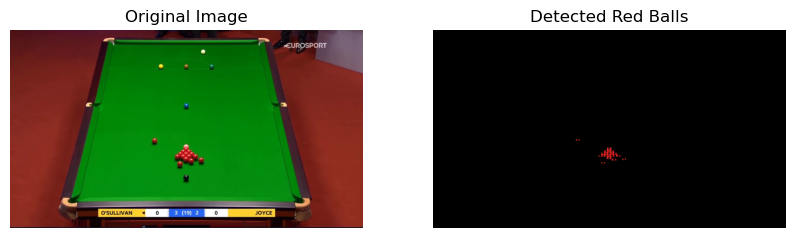

In [3]:
# Display the original image and the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Detected Red Balls')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

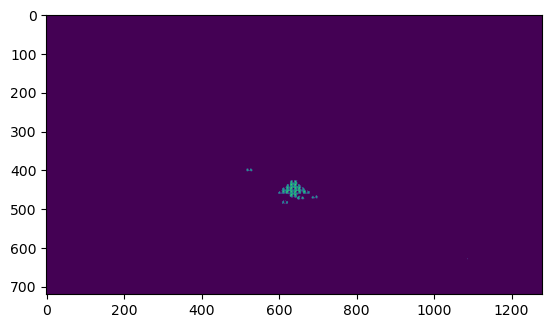

In [4]:
# Get grayscale
imgray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
plt.imshow(imgray)

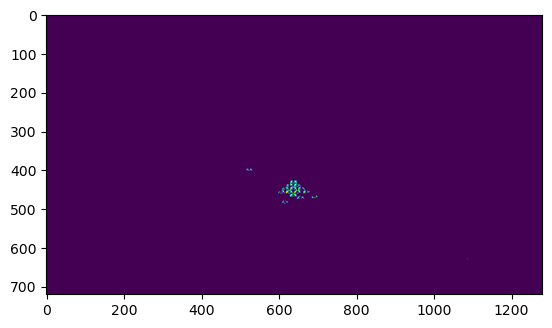

In [5]:
# Using grayscale get binary image so we can find contours
ret, thresh = cv2.threshold(imgray, 80, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(thresh)

num circles: 15


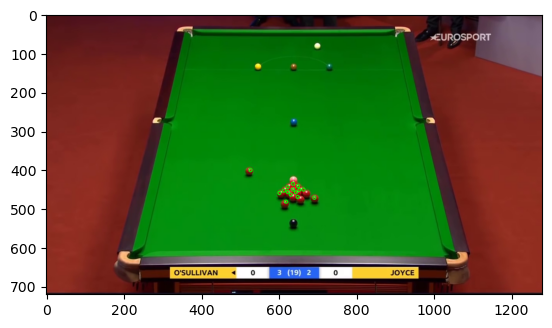

In [7]:
# Apply gaussian blur to get smoother images
#blurred = cv2.GaussianBlur(thresh, (11, 11), 2, 2)
blurred = gaussian_blur(thresh, kernel_size=5, sigma=2.0)

# Use hough circles because the contours look circular-ish
circles = cv2.HoughCircles(
    blurred, 
    cv2.HOUGH_GRADIENT, 
    dp=1.5, 
    minDist=10, 
    param1=20, 
    param2=6, 
    minRadius=3, 
    maxRadius=5
)

# Prepare the output image
output = image.copy()
circle_centers = []

# Check if circles are detected
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    print(f'num circles: {len(circles)}')
    for (x, y, r) in circles:
        # Draw the circle in the output image
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        # Store the center of the circle
        circle_centers.append((x, y))

    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    circle_centers = np.array(circle_centers)

In [8]:
def gaussian_elimination(A, b): # adapted from pseudocode in https://www.cs.gordon.edu/courses/mat342/handouts/gauss.pdf
    n = len(b)
    
    # Augment the matrix A with the vector b to form an augmented matrix
    Ab = np.hstack([A, b.reshape(-1, 1)])
    
    for i in range(n):
        # Partial pivoting: find the row with the largest element in the current column
        max_row = np.argmax(np.abs(Ab[i:, i])) + i
        # Swap the current row with the row of the largest element
        if i != max_row:
            Ab[[i, max_row]] = Ab[[max_row, i]]
        
        # Normalize the pivot row by making the diagonal element 1
        Ab[i] = Ab[i] / Ab[i, i]
        
        # Eliminate the entries below the pivot
        for j in range(i + 1, n):
            Ab[j] = Ab[j] - Ab[j, i] * Ab[i]
    
    # Back substitution to find the solution vector x
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = Ab[i, -1] - np.sum(Ab[i, i+1:n] * x[i+1:n])
    
    return x

# Map coordinates using a homography transformation
def map_coordinates_homography(source_coords, dest_coords):
    
    N = source_coords.shape[0]
    A = np.zeros((2 * N, 8))
    b = np.zeros(2 * N)
    
    # Construct the system of linear equations to solve for the homography matrix
    for i in range(N):
        x, y = source_coords[i]
        u, v = dest_coords[i]
        A[2 * i] = [x, y, 1, 0, 0, 0, -u * x, -u * y]
        A[2 * i + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y]
        b[2 * i] = u
        b[2 * i + 1] = v
    
    # Solve the linear system to find the homography matrix coefficients
    coeffs = gaussian_elimination(A, b)
    H = np.array([[coeffs[0], coeffs[1], coeffs[2]],
                  [coeffs[3], coeffs[4], coeffs[5]],
                  [coeffs[6], coeffs[7], 1]])
    
    return H

In [9]:
red_balls = circle_centers.copy()

# From previous notebook
yellow_ball = np.array([548, 132])
green_ball = np.array([737, 136])
brown_ball = np.array([640, 134])
blue_ball = np.array([639, 276])
pink_ball = np.array([640, 421])
black_ball = np.array([642, 537])

yellow_ball_3d = np.array([548, 132, 0.02625])
green_ball_3d = np.array([737, 136, 0.02625])
brown_ball_3d = np.array([640, 134, 0.02625])
blue_ball_3d = np.array([639, 276, 0.02625])
pink_ball_3d = np.array([640, 421, 0.02625])
black_ball_3d = np.array([642, 537, 0.02625])

# Corner coordinates and the widthxlength ratio
side_view_corners = np.array([[345, 35], [929, 33], [196, 634], [1072, 639]])
table_ratio = [1.778, 3.569]

In [10]:
# Proccess the destination points for a top-down view of the table
width = 1000  # arbitrary width for the top-down view
height = int(width * table_ratio[1] / table_ratio[0])
top_view_corners = np.array([[0, 0], [width, 0], [0, height], [width, height]])

# Compute the perspective transformation matrix
matrix = map_coordinates_homography(side_view_corners.astype(np.float32), top_view_corners.astype(np.float32))


In [11]:
# Function to transform coordinates
def transform_coords(coords, matrix):
    coords_homogeneous = np.hstack([coords, np.ones((coords.shape[0], 1))])
    transformed_coords = matrix @ coords_homogeneous.T
    transformed_coords /= transformed_coords[2, :]
    return transformed_coords[:2, :].T

In [12]:
# Transform all ball coordinates
red_balls_top_view = transform_coords(red_balls, matrix)
yellow_ball_top_view = transform_coords(yellow_ball.reshape(1, -1), matrix)
green_ball_top_view = transform_coords(green_ball.reshape(1, -1), matrix)
brown_ball_top_view = transform_coords(brown_ball.reshape(1, -1), matrix)
blue_ball_top_view = transform_coords(blue_ball.reshape(1, -1), matrix)
pink_ball_top_view = transform_coords(pink_ball.reshape(1, -1), matrix)
black_ball_top_view = transform_coords(black_ball.reshape(1, -1), matrix)

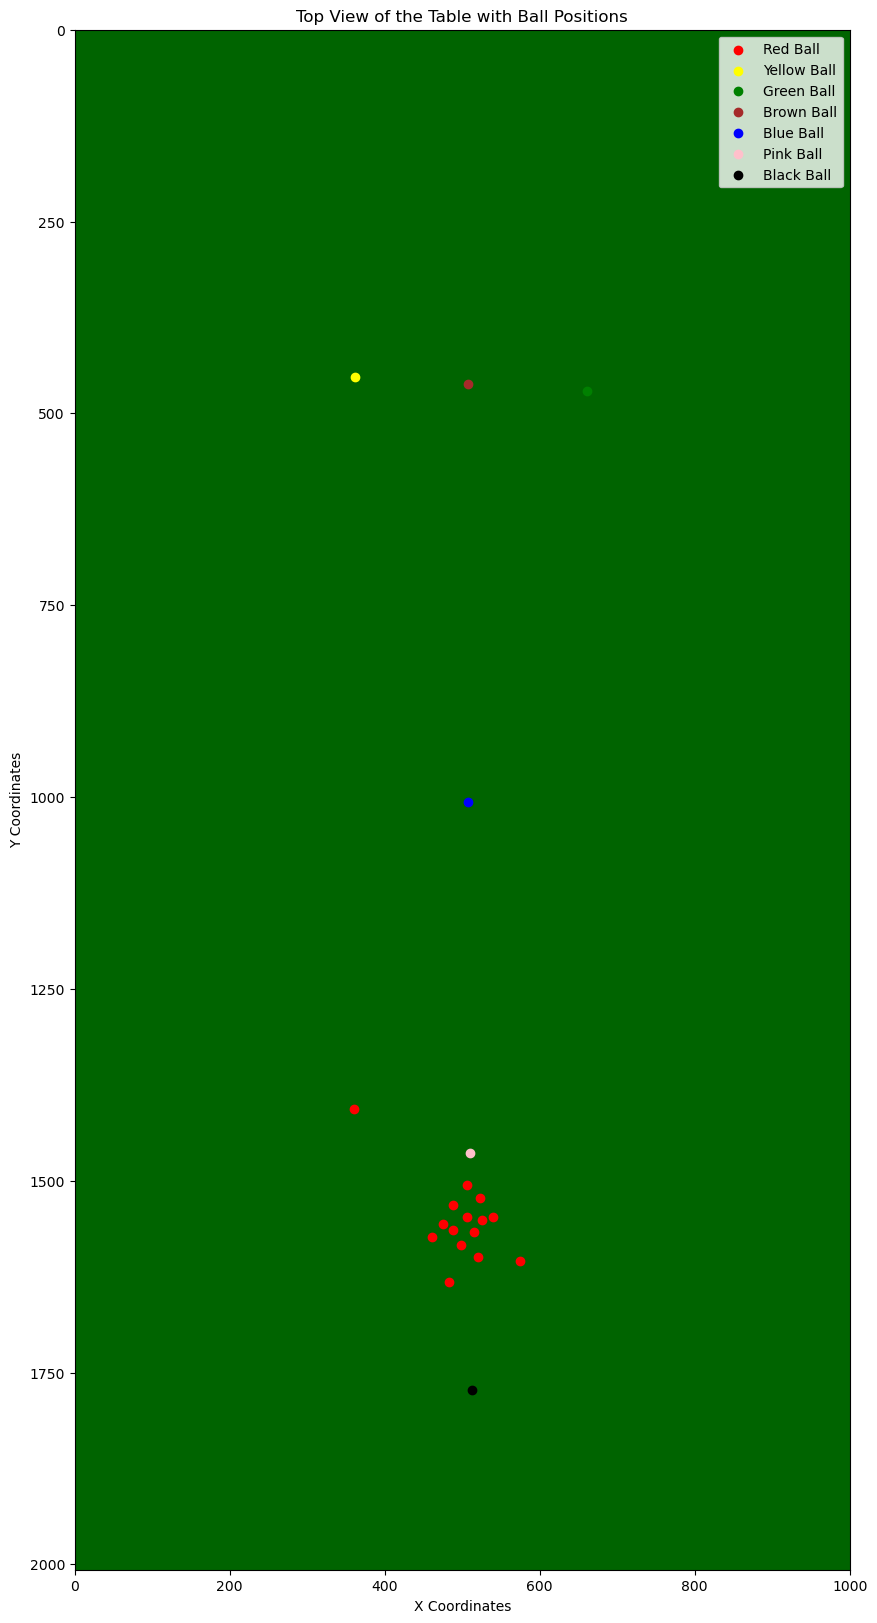

In [13]:
plt.figure(figsize=(10, int(10 * table_ratio[1] / table_ratio[0])))
plt.scatter(*red_balls_top_view.T, color='red', label='Red Ball')
plt.scatter(*yellow_ball_top_view.T, color='yellow', label='Yellow Ball')
plt.scatter(*green_ball_top_view.T, color='green', label='Green Ball')
plt.scatter(*brown_ball_top_view.T, color='brown', label='Brown Ball')
plt.scatter(*blue_ball_top_view.T, color='blue', label='Blue Ball')
plt.scatter(*pink_ball_top_view.T, color='pink', label='Pink Ball')
plt.scatter(*black_ball_top_view.T, color='black', label='Black Ball')
plt.xlim(0, width)
plt.ylim(height, 0)
plt.legend()
plt.title("Top View of the Table with Ball Positions")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.gca().set_facecolor('darkgreen')
plt.show()